In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import multivariate_normal as mvn
from sklearn.preprocessing import StandardScaler



In [2]:
df = pd.read_csv('Churn_Modelling.csv')

In [3]:
df['HasBalance'] = (df['Balance'] > 0).astype(int)
print(df['HasBalance'].value_counts(normalize=True))

HasBalance
1    0.6383
0    0.3617
Name: proportion, dtype: float64


In [4]:
categorical_cols = ['Geography', 'Gender']
for col in categorical_cols:
    print(f"\n🔡 Unique values in '{col}': {df[col].unique()}")

df = pd.get_dummies(df, columns=['Geography'], drop_first=True)


🔡 Unique values in 'Geography': ['France' 'Spain' 'Germany']

🔡 Unique values in 'Gender': ['Female' 'Male']


In [5]:
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})


In [6]:
df_clean = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)


In [7]:
features = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance',
            'NumOfProducts', 'HasCrCard', 'IsActiveMember',
            'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'HasBalance']

X = df_clean[features].values
y = df_clean['Exited'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
numeric_cols = [0, 2, 3, 4, 5, 8]  

scaler = StandardScaler()
X_train[:, numeric_cols] = scaler.fit_transform(X_train[:, numeric_cols])
X_test[:, numeric_cols] = scaler.transform(X_test[:, numeric_cols])

In [10]:
class gaussBayes():

    def fit(self, X, y, epsilon=1e-3):
        self.params = {}
        self.priors = {}

        self.K = set(y.astype(int))
        
        for k in self.K:
            X_k = X[y==k,:]
            N_k, d = X_k.shape
            mu_k = X_k.mean(axis=0)
            cov_k = (1/(N_k-1)) * np.matmul((X_k-mu_k).T, (X_k-mu_k))+epsilon*np.identity(d)
            self.params[k] = {'mean':mu_k, 'cov':cov_k}
            self.priors[k] = len(X_k)/len(X)

    def predict(self, X):
        N, d = X.shape
        P_hat = np.zeros((N, len(self.K)))

        for k, l in self.params.items():
            P_hat[:,k] = mvn.logpdf(X, l['mean'], l['cov']) + np.log(self.priors[k])

        return P_hat.argmax(axis=1)
  
def accuracy(y, y_hat):
    return np.mean(y == y_hat)

In [11]:
gaussNB = gaussBayes()

In [12]:
gaussNB.fit(X_train, y_train, epsilon=0.05)


In [13]:
y_pred = gaussNB.predict(X_test)

In [14]:
def confusionMatrix(y,y_hat):
    plt.figure(figsize=(10,7))
    y_actu = pd.Series(y, name='Actual')
    y_pred = pd.Series(y_hat, name='Predicted')
    cm = pd.crosstab(y_actu, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy: 0.8335
Confusion Matrix:
[[1546   47]
 [ 286  121]]
None

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1593
           1       0.72      0.30      0.42       407

    accuracy                           0.83      2000
   macro avg       0.78      0.63      0.66      2000
weighted avg       0.82      0.83      0.80      2000



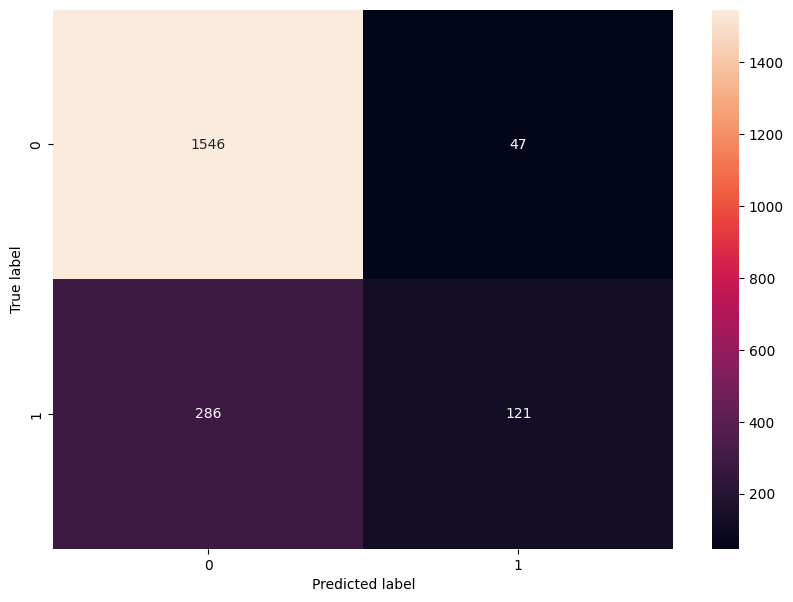

In [15]:
print(f"Accuracy: {accuracy(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(confusionMatrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [16]:
def sigmoid(h):
    return 1/(1+np.exp(-h))
def cross_entropy(y, p_hat):
    epsilon = 1e-10  
    p_hat = np.clip(p_hat, epsilon, 1 - epsilon)
    return -(1/len(y)) * np.sum(y*np.log(p_hat) + (1 - y)*np.log(1 - p_hat))
def accuracy(y,y_hat):
    return np.mean(y==y_hat)

In [17]:
class logisticRegression():
    def __init__(self, thresh=0.5, seed=None):
        self.W = None
        self.b = None
        self.thresh = thresh
        if seed is not None:
            np.random.seed(seed)
        
    def fit(self, X, y, eta=1e-3, epochs=1000, show_curve=True):
        epochs = int(epochs)
        N, D = X.shape

        self.W = np.random.randn(D) * 0.01
        self.b = float(np.random.randn() * 0.01)

        J = np.zeros(epochs)

        for epoch in range(epochs):
            p_hat = self.__forward__(X)
            J[epoch] = cross_entropy(y, p_hat)
            self.W -= eta * (1/N) * X.T @ (p_hat - y)
            self.b -= eta * (1/N) * np.sum(p_hat - y)

        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("Epochs")
            plt.ylabel("Loss (Cross Entropy)")
            plt.title("Training Loss Curve")
            plt.show()

    def __forward__(self, X):
        return sigmoid(X @ self.W + self.b)
        
    def predict(self, X):
        return (self.__forward__(X) >= self.thresh).astype(np.int32)

In [18]:
def main():
    features = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 
            'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
            'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'HasBalance']

    X = df[features].values
    y = df['Exited'].values

    X = np.array(X, dtype=float)
    y = np.array(y, dtype=int)

    numeric_cols = [0, 2, 3, 4, 5, 8]  # indexes of numeric columns to scale

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train[:, numeric_cols] = scaler.fit_transform(X_train[:, numeric_cols])
    X_test[:, numeric_cols] = scaler.transform(X_test[:, numeric_cols])

    log_reg = logisticRegression(seed=42)
    log_reg.fit(X_train, y_train, eta=1e-2, epochs=30000)

    y_hat_train = log_reg.predict(X_train)
    y_hat_test = log_reg.predict(X_test)

    print(f"Training Accuracy: {accuracy(y_train, y_hat_train):.4f}")
    print(f"Test Accuracy: {accuracy(y_test, y_hat_test):.4f}")

    print("\nConfusion Matrix (Test):")
    print(confusion_matrix(y_test, y_hat_test))

    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_hat_test, digits=4))

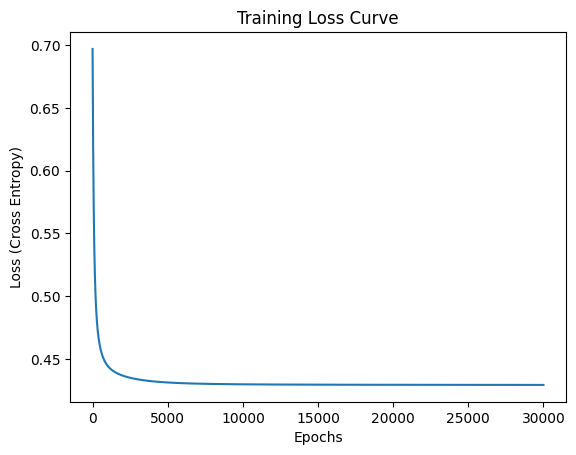

Training Accuracy: 0.8109
Test Accuracy: 0.8090

Confusion Matrix (Test):
[[1540   53]
 [ 329   78]]

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.8240    0.9667    0.8897      1593
           1     0.5954    0.1916    0.2900       407

    accuracy                         0.8090      2000
   macro avg     0.7097    0.5792    0.5898      2000
weighted avg     0.7775    0.8090    0.7676      2000



In [19]:
if __name__ == "__main__":
    main()